### In what proportion of the brain can we confidently say that there are multiple populations of crossing fibers?

Let's for this notebook go with the (probably iffy, given the noise) assumption that the tensor model would never fit the data well in regions of crossing fibers. 

This makes our life easy, because we can simply check whether CSD or DTI fit the data better for a given data-set.

Let's do that with a few different measurement conditions. In particular, sweeping through b-values from 1000 to 4000 $s/mm^2$. All measured at 2 mm isotropic. 


In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
sns.set(style='white')
import pandas as pd

In [2]:
import nibabel as nib
import dipy.data as dpd
import dipy.core.gradients as dpg
import dipy.reconst.cross_validation as xval

Autodownload the data from the Stanford libraries. I a intentionally only going to analyze a single measurement using split-half cross-validation, to demonstrate that this can be done on *any* data-set, not only on test-retest data-sets.

In [3]:
import urllib as url
import os.path as op

top_url = 'https://stacks.stanford.edu/file/druid:ng782rw8378/'
for b in [1000, 2000, 4000]:
    for ext in ['.nii.gz', '.bvecs', '.bvals']:
        fname = 'SUB1_b%s_1%s'%(b, ext)
        if not op.exists('./data/' + fname):
            url.urlretrieve(op.join(top_url, fname), './data/' + fname)

In [4]:
hardi_img, gtab, labels_img = dpd.read_stanford_labels()
labels = labels_img.get_data()
t1 = dpd.read_stanford_t1()
t1_data = t1.get_data()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/stanford_hardi 
All files already in /Users/arokem/.dipy/stanford_hardi.
All files already in /Users/arokem/.dipy/stanford_hardi.


In [5]:
white_matter = (labels == 1) | (labels == 2)

In [6]:
import dipy.reconst.csdeconv as csd
import dipy.reconst.dti as dti

In [7]:
data = {}
gtab = {}
for b in [1000, 2000, 4000]:
    data[b] = nib.load(op.join('data', 'SUB1_b%s_1.nii.gz'%b)).get_data()
    gtab[b] = dpg.gradient_table(op.join('./data', 'SUB1_b%s_1.bvals'%b),
                                 op.join('./data', 'SUB1_b%s_1.bvecs'%b))

### Compare models

We set up a function to fit the models using k-fold cross-validation, and calculate goodness-of-fit as the coefficient of determination.

In [8]:
def compare_models(gtab, data, mask, folds=2):
    # CSD model setup (requires calculation of a response function. We'll do that automatically first)
    response, ratio = csd.auto_response(gtab, data, roi_radius=10, fa_thr=0.7)
    csd_model = csd.ConstrainedSphericalDeconvModel(gtab, response)
    # DTI model setup:
    dti_model = dti.TensorModel(gtab)
    # Predict with k-fold CV:
    csd_pred = xval.kfold_xval(csd_model, data, folds, response, mask=mask)
    dti_pred = xval.kfold_xval(dti_model, data, folds, mask=mask)
    # Calculate coefficient of determination
    cod_csd = xval.coeff_of_determination(csd_pred, data)
    cod_dti = xval.coeff_of_determination(dti_pred, data)
    return cod_csd, cod_dti

In [9]:
dti_results = {}
csd_results = {}
for bval in [1000, 2000, 4000]:
    this_data = data[bval]
    this_gtab = gtab[bval]
    cod_csd, cod_dti = compare_models(this_gtab, this_data, white_matter)
    dti_results[bval] = cod_dti
    csd_results[bval] = cod_csd

### Visualize: 

We can visualize this comparison several different ways: 

- Maps of the difference between goodness of fit in the white matter
- Jointplots of the distributions of goodness of fit in all the voxels


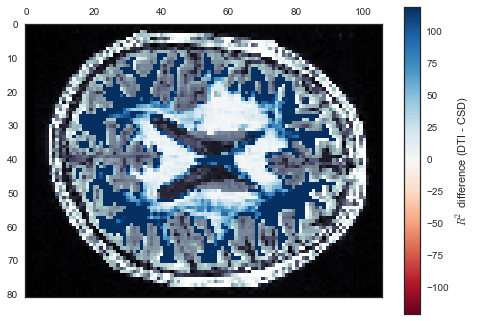

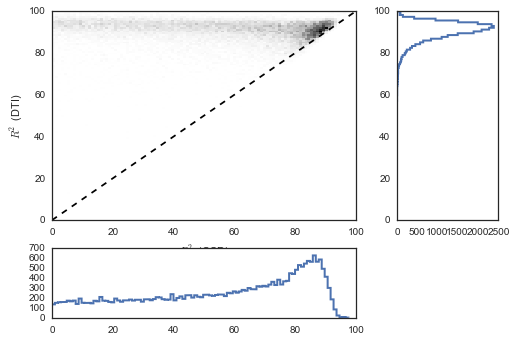

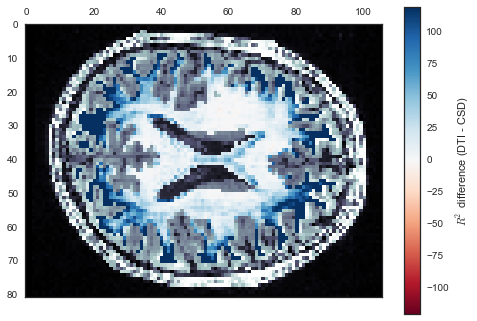

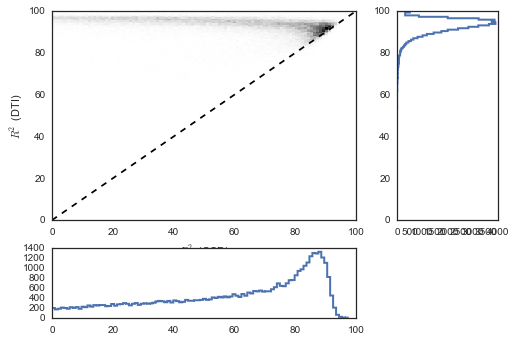

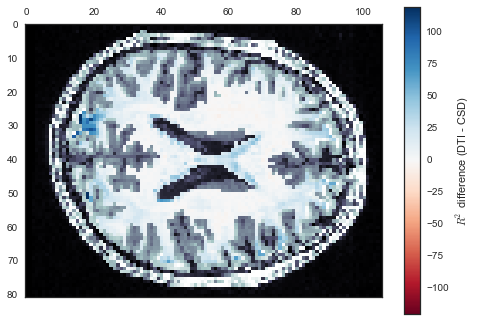

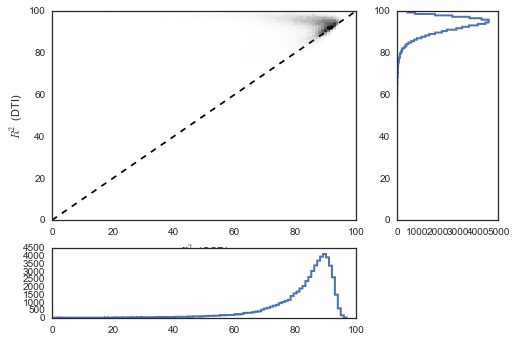

In [86]:
for bval in [1000, 2000, 4000]:
    this_csd = csd_results[bval]
    this_dti = dti_results[bval]
    cod_diff = this_dti - this_csd
    cod_diff[0,0,0] = -np.max(cod_diff)
    cod_diff[0,0,1] = -np.min(cod_diff)
    fig, ax = plt.subplots()
    vol = np.zeros_like(cod_diff) * np.nan
    vol[white_matter] = cod_diff[white_matter]
    ax.matshow(t1_data[:, :, 40], cmap=cm.bone)
    im = ax.matshow(vol[:, :, 40], cmap=cm.RdBu, vmax=120, vmin=-120)
    cb = plt.colorbar(im)
    cb.set_label('$R^2$ difference (DTI - CSD)')
    fig2, ax2 = plt.subplots()
    
    idx = (csd_results[bval] > 0) * (dti_results[bval] > 0 )
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[3,1], height_ratios=[3,1])
    ax2 = plt.subplot(gs[0,0])
    axx = plt.subplot(gs[1,0], sharex=ax2)
    axy = plt.subplot(gs[0,1], sharey=ax2)
    ax2.hist2d(csd_results[bval][idx], 
               dti_results[bval][idx], bins=100)
    axx.hist(csd_results[bval][idx], bins=100, histtype='step', linewidth=2)
    axy.hist(dti_results[bval][idx], bins=100, histtype='step', linewidth=2, orientation='horizontal')
    ax2.plot([0, 100], [0, 100], 'k--')
    ax2.set_xlabel('$R^2$ (CSD)')
    ax2.set_ylabel('$R^2$ (DTI)')
    ax2.set_xlim([0, 100])
    ax2.set_ylim([0, 100])